In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import glob
import sys
import os
import cv2
import numpy as np
print(cv2.__version__)

3.1.0


---

## Load Traffic Lights data



In [3]:
from data_utils import load_tl_extracts

In [4]:
desired_dim = (32,32)

In [5]:
data_dirs = ['data/tl-extract-train', 'data/tl-extract-test', 'data/tl-extract-additional']

In [6]:
# OpenCV uses H, W, C. and C is ordered BGR
x, y = load_tl_extracts(data_dirs, desired_dim)

In [7]:
x.shape

(24504, 32, 32, 3)

In [8]:
y.shape

(24504,)

In [9]:
y_set = set(y)
y_dict = {y: i for i,y in enumerate(y_set)}
y_n = [y_dict[el] for el in y]
n_classes = len(y_set)

---

## Filter only classes relevant for us



{'green': 3,
 'greenleft': 10,
 'greenright': 8,
 'greenstraight': 5,
 'greenstraightleft': 7,
 'greenstraightright': 1,
 'off': 4,
 'red': 6,
 'redleft': 2,
 'redright': 9,
 'redstraight': 11,
 'redstraightleft': 12,
 'yellow': 0}

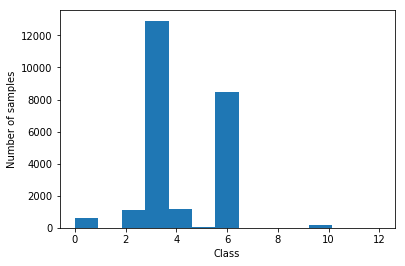

In [10]:
#distribution of examples per class
plt.hist(y_n, bins=n_classes);
plt.xlabel('Class');
plt.ylabel('Number of samples');
y_dict

In [11]:
relevant = ['green','off','yellow','red']
x2 = x[np.isin(y, relevant)]
y2 = y[np.isin(y, relevant)]

In [12]:
x2.shape

(23164, 32, 32, 3)

In [13]:
y2_set = set(y2)
y2_dict = {y: i for i,y in enumerate(y2_set)}
y2_n = [y_dict[el] for el in y2]
n_classes = len(y2_set)

{'green': 3, 'off': 1, 'red': 0, 'yellow': 2}

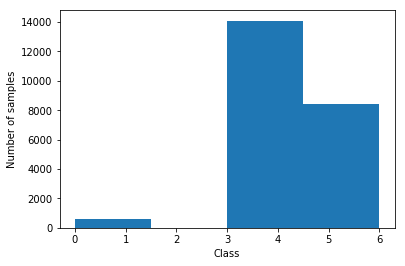

In [14]:
#distribution of examples per class
plt.hist(y2_n, bins=n_classes);
plt.xlabel('Class');
plt.ylabel('Number of samples');
y2_dict

---

## Visualize Data



In [15]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

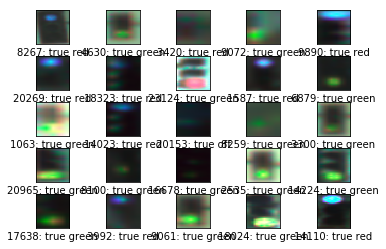

In [16]:
# randomly show grid 5x5 examples from training data set and their true class
rows = 5
cols = 5
cls = None
show_images(x2, y2, rows, cols, cls)

----

## Preprocess and split train/test


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [18]:
x = x2
y = y2

In [19]:
# apply One-Hot Encoding for class labels. at the moment they are integers 0..42
encoder = LabelBinarizer()
encoder.fit(y)
y_onehot = encoder.transform(y)
# Change to float32, so it can be multiplied against the features in 
# TensorFlow, which are float32
y_onehot = y_onehot.astype(np.float32)

In [20]:
pct_train = 85.
pct_valid = 15.
random_state = 123

train_features, val_features, train_labels, val_labels = train_test_split(
                                                            x, y_onehot, 
                                                            train_size = pct_train/100., 
                                                            test_size = pct_valid/100.,
                                                            random_state = random_state)

In [21]:
train_features.shape

(19689, 32, 32, 3)

In [22]:
train_features.dtype

dtype('uint8')

In [23]:
train_labels.shape

(19689, 4)

In [24]:
def normalize_data(image_data):
    return np.true_divide(np.subtract(image_data, np.array([128.])), np.array([256.]))

In [25]:
# normalised images in training and test sets
#x_train_norm = normalize_data(X_train)


----

## Design and Test a Model Architecture


In [26]:
import tensorflow as tf
from tqdm import tqdm
import math
from datetime import datetime

In [40]:
class TrafficLightsClassifier:
    # initialization defaults as class variables
    _trunc_normal_stddev = 0.05
    _bias_init = 0.1
    _L1_kernel_size = 5
    _L1_out_channels = 64
    _kernel1_strides = [1, 1, 1, 1]
    _pool1_kernel = [1, 2, 2, 1]
    _pool1_strides = [1, 2, 2, 1]
    _L2_kernel_size = 5
    _L2_out_channels = 32
    _kernel2_strides = [1, 1, 1, 1]
    _pool2_kernel = [1, 2, 2, 1]
    _pool2_strides = [1, 2, 2, 1]
    
    def __init__(self):
        self._global_step = None
        # input placeholders
        self._images = None
        self._labels = None
        # transform input
        self._images_float = None
        self._images_std = None
        # layer setup
        # Layer 1
        self._kernel1 = None
        self._conv1 = None
        self._bias1 = None
        self._biased1 = None
        self._conv1r = None
        self._pool1 = None
        # Layer 2
        self._kernel2 = None
        self._conv2 = None
        self._bias2 = None
        self._biased2 = None
        self._conv2r = None
        self._pool2 = None
        # reshape
        self._reshape2 = None
        # dropout
        self._keep_prob = None
        self._dropout = None
        # Level 3 FC
        self._weights3 = None
        self._biases3 = None
        self._local3 = None
        # softmax
        self._prediction = None
        self._cross_entropy = None
        self._loss = None
        self._true_class = None
        self._predicted_class = None
        self._accuracy = None
        # savers
        self._model_param_file = None
        self._saver = None
        self._summary_dir = None
        self._summaries = None
        self._summary_writer = None
        # optimizer
        self._optimizer = None
    
    def variable_summaries(self, var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean/'+str(var.name).replace(":","_"), mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev/'+str(var.name).replace(":","_"), stddev)
            tf.summary.scalar('max/'+str(var.name).replace(":","_"), tf.reduce_max(var))
            tf.summary.scalar('min/'+str(var.name).replace(":","_"), tf.reduce_min(var))
            tf.summary.histogram('histogram/'+str(var.name).replace(":","_"), var)
    
    def define_model(self, features_shape, labels_shape):
        """Takes batch of OpenCV images of type uint8. Does normalization internally"""
        self._global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        # placeholders
        self._images = tf.placeholder(tf.uint8, shape=features_shape, name='images')
        self._labels = tf.placeholder(tf.float32, name='labels')

        # convert type and standardise image to [0,1] values
        self._images_float = tf.image.convert_image_dtype(self._images, tf.float32)
        self._images_std = tf.map_fn(lambda img: tf.image.per_image_standardization(img), self._images_float)
        #self._images_std = tf.image.per_image_standardization(self._images_float)
                
        # layer 1
        k1_params = [self._L1_kernel_size, self._L1_kernel_size, features_shape[3], self._L1_out_channels]
        self._kernel1 = tf.Variable(tf.truncated_normal(k1_params, stddev=self._trunc_normal_stddev), name='L1_kernel')
        self.variable_summaries(self._kernel1)
        self._conv1 = tf.nn.conv2d(self._images_std, self._kernel1, strides=self._kernel1_strides, padding='SAME')
        tf.summary.histogram('conv1', self._conv1)
        self._bias1 = tf.Variable(tf.constant(np.ones(self._L1_out_channels, np.float32)*self._bias_init), name='L1_bias')
        self.variable_summaries(self._bias1)
        self._biased1 = tf.nn.bias_add(self._conv1, self._bias1)
        self._conv1r = tf.nn.relu(self._biased1)
        tf.summary.histogram('conv1r', self._conv1r)
        self._pool1 = tf.nn.max_pool(self._conv1r, 
                                       ksize = self._pool1_kernel, 
                                       strides = self._pool1_strides,
                                       padding='SAME')
        tf.summary.histogram('pool1', self._pool1)
        # layer 2
        k2_params = [self._L2_kernel_size, self._L2_kernel_size, self._L1_out_channels, self._L2_out_channels]
        self._kernel2 = tf.Variable(tf.truncated_normal(k2_params, stddev=self._trunc_normal_stddev), name='L2_kernel')
        self.variable_summaries(self._kernel2)
        self._conv2 = tf.nn.conv2d(self._pool1, self._kernel2, strides=self._kernel2_strides, padding='SAME')
        tf.summary.histogram('conv2', self._conv2)
        self._bias2 = tf.Variable(tf.constant(np.ones(self._L2_out_channels, np.float32)*self._bias_init), name='L2_bias')
        self.variable_summaries(self._bias2)
        self._biased2 = tf.nn.bias_add(self._conv2, self._bias2)
        self._conv2r = tf.nn.relu(self._biased2)
        tf.summary.histogram('conv2r', self._conv2r)
        self._pool2 = tf.nn.max_pool(self._conv2r, 
                               ksize = self._pool2_kernel,
                               strides = self._pool2_strides, 
                               padding='SAME')
        tf.summary.histogram('pool2', self._pool2)
        # reshape
        shape = self._pool2.get_shape().as_list()
        dim = np.prod(shape[1:])
        self._reshape2 = tf.reshape(self._pool2, [-1, dim])
        # DROPOUT
        self._keep_prob = tf.placeholder(tf.float32, name='dropout_keep_probability')
        self._dropout = tf.nn.dropout(self._reshape2, self._keep_prob)
        tf.summary.histogram('dropout', self._dropout)
        tf.summary.scalar('dropout_keep_probability', self._keep_prob)
        # layer 3 fully connected
        init_range = math.sqrt(6.0 / (dim + labels_shape[1]))
        self._weights3 = tf.Variable(tf.random_uniform([dim, labels_shape[1]], -init_range, init_range), name='FC1_weights')
        self.variable_summaries(self._weights3)
        self._biases3 = tf.Variable(tf.constant(np.ones(labels_shape[1], np.float32)*self._bias_init), name='FC1_bias')
        self.variable_summaries(self._biases3)
        self._local3 = tf.matmul(self._dropout, self._weights3) + self._biases3
        tf.summary.histogram('local3', self._local3)
        # softmax
        self._prediction = tf.nn.softmax(self._local3)
        tf.summary.histogram('prediction', self._prediction)
        # Cross entropy
        self._cross_entropy = tf.reduce_mean(-tf.reduce_sum(
                                            self._labels * tf.log(tf.clip_by_value(self._prediction,1e-10,1.0)), 
                                            reduction_indices=[1]))
        tf.summary.scalar('xentropy', self._cross_entropy)
        # training loss
        self._loss = tf.reduce_mean(self._cross_entropy)
        tf.summary.scalar('loss', self._loss)
        # accuracy
        self._true_class      = tf.argmax(self._labels, 1)
        self._predicted_class = tf.argmax(self._prediction, 1)
        self._accuracy = tf.reduce_mean(tf.cast(tf.equal(self._predicted_class, self._true_class), tf.float32))
        tf.summary.histogram('accuracy', self._accuracy)

    def set_save_files(self, model_param_file, summary_dir=None):
        """ adds ops to save all variables. and merge_all op for summaries. """
        self._model_param_file = model_param_file
        self._saver = tf.train.Saver()
        if summary_dir is not None:
            self._summary_dir = summary_dir
            self._summaries = tf.summary.merge_all()
            
    def create_session(self, learning_rate=0.001):
        """ 
        Prepares session
        
        Creates TF session, 
        Creates optimizer op, 
        Creates init op,
        Configures GPU usage
        Runs init op
        Configures summary writer
        
        Prev actions:
            define_model
            set_save_files
        Next actions:
            restore_variables
            train
            predict
            close_session
        """
        # optimizer needs to be here to initialize its variables
        # leaving learning rate
        self._optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self._loss, global_step=self._global_step)
        
        # init
        init = tf.global_variables_initializer()
        #init = tf.initialize_all_variables()
        #GPU config
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.9
        #session
        self._session = tf.Session(config=config)
        self._session.run(init)
        #summary writer
        if self._summary_dir is not None:
            self._summary_writer = tf.summary.FileWriter(self._summary_dir, self._session.graph)

    def restore_variables(self):
        """
        Restore model variables from file
        """
        if self._session is not None:
            self._saver.restore(self._session, self._model_param_file)
        
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
            
    def train(self, 
              train_images, 
              train_labels, 
              validation_images=None, 
              validation_labels=None, 
              learning_rate=0.001, 
              dropout_keep_probability=0.5,
              batch_size=150, 
              epochs=50, 
              max_iterations_without_improvement=5):
        
        # Measurements use for graphing loss and accuracy
        best_validation_accuracy = 0.0
        last_improvment_epoch = 0
        loss_epoch = []
        train_acc_epoch = []
        valid_acc_epoch = []

        st = datetime.now()

        a_ = 0

        for epoch_i in range(epochs):
            # train for one epoch

            # random training set permutation for each epoch
            perm_index = np.random.permutation(len(train_images))
            train_images = train_images[perm_index,:,:,:]
            train_labels = train_labels[perm_index]

            # running optimization in batches of training set
            batch_count = int(math.ceil(len(train_images)/batch_size))
            batches_pbar = tqdm(range(batch_count), desc='Train Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            for batch_i in batches_pbar:
                batch_start = batch_i*batch_size
                batch_images = train_images[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]
                # Run optimizer and get loss
                _, l, _summ = self._session.run(
                    [self._optimizer, self._loss, self._summaries],
                    feed_dict={self._images: batch_images, 
                               self._labels: batch_labels, 
                               self._keep_prob: dropout_keep_probability})
            # write summaries once per epoch
            _summ = self._session.run(
                [self._summaries],
                feed_dict={self._images: batch_images, 
                           self._labels: batch_labels, 
                           self._keep_prob: dropout_keep_probability})
            self._summary_writer.add_summary(_summ[0], epoch_i)

            # Log accuracy every epoch. have to calculate accuracy in batches as cannot 
            # fit entire test set on GPU
            # training accuracy
            batch_count = int(math.ceil(len(train_images)/batch_size))
            batches_pbar = tqdm(range(batch_count), desc='Train Accuracy Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            l = 0.
            a = 0.
            for batch_i in batches_pbar:
                batch_start = batch_i*batch_size
                batch_images = train_images[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]
                l_, a_ = self._session.run(
                    [self._loss, self._accuracy],
                    feed_dict={self._images: batch_images, 
                               self._labels: batch_labels, 
                               self._keep_prob: 1.0})
                l += l_ * len(batch_images)
                a += a_ * len(batch_images)
            loss_epoch.append(l / len(train_images))
            train_acc_epoch.append(a / len(train_images))
            
            if validation_images is None:
                validation_images = train_images
                validation_labels = train_labels
            
            # validation accuracy
            batch_count = int(math.ceil(len(validation_images)/batch_size))
            batches_pbar = tqdm(range(batch_count), desc='Val Accuracy Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            a = 0.
            for batch_i in batches_pbar:
                batch_start = batch_i*batch_size
                batch_images = validation_images[batch_start:batch_start + batch_size]
                batch_labels = validation_labels[batch_start:batch_start + batch_size]
                # Run optimizer and get loss
                a_ = self._session.run(
                    [self._accuracy],
                    feed_dict={self._images: batch_images, 
                               self._labels: batch_labels, 
                               self._keep_prob: 1.0})
                a += a_[0] * len(batch_images)
            validation_accuracy = a / len(validation_images)
            valid_acc_epoch.append(validation_accuracy)
            print('epoch {}, val accuracy: {}'.format(epoch_i, validation_accuracy))
            if (validation_accuracy > best_validation_accuracy):
                best_validation_accuracy = validation_accuracy
                last_improvment_epoch = epoch_i
                # save checkpoint every time accuracy improved during the epoch
                save_path = self._saver.save(self._session, self._model_param_file, global_step=self._global_step)
                print("checkpoint saved to {}".format(save_path))
                print('***') # signify accuracy improvement iteration
            else:
                if (epoch_i - last_improvment_epoch >= max_iterations_without_improvement):
                    break # stop learning
        print('runtime: {}'.format(datetime.now()-st))
        print('best val accuracy: {}'.format(best_validation_accuracy))
        print('epochs: {}'.format(epoch_i))
        return loss_epoch, train_acc_epoch, valid_acc_epoch, best_validation_accuracy

    def predict(self, 
              images, 
              true_labels=None, 
              batch_size=150):

        # Measurements use for graphing loss and accuracy
        predicted_probabilities = []
        predicted_classes = []
        accuracy = 0
        batch_count = int(math.ceil(len(images)/batch_size))
        for batch_i in range(batch_count):
            batch_start = batch_i*batch_size
            ops = [self._prediction, self._predicted_class]
            feed_dict={self._images: images[batch_start:batch_start + batch_size], 
                       self._keep_prob: 1.0}
            if true_labels is not None:
                ops.append(self._accuracy)
                feed_dict[self._labels] = true_labels[batch_start:batch_start + batch_size]
            # Run optimizer and get loss
            output = self._session.run(ops, feed_dict=feed_dict)
            predicted_probabilities.append(output[0])
            predicted_classes.append(output[1])
            accuracy += output[2] * len(feed_dict[self._images])
        accuracy /= len(images)
        return np.vstack(predicted_probabilities), np.hstack(predicted_classes), accuracy
        

Below is Tensorboard visualisation of the main part of my network (before softmax).

Here is the description of it:

1. input features. shape: (?, 32, 32, 3)
2. convolution. kernel: [5,5] 3 input channels, 64 output channels. strides [1,1,1,1]. SAME padding.
3. add bias
4. relu
5. max pool. strides [1,2,2,1]. kernel [1,2,2,1]. SAME padding
6. convolution. kernel: [5,5] 64 input channels, 32 output channels. strides [1,1,1,1]. SAME padding.
7. add bias
8. relu
9. max pool. strides [1,2,2,1]. kernel [1,2,2,1]. SAME padding
10. reshape to flatten features. 2048 features
11. dropout with keep_probability=0.5
12. fully connected W*x+bias. output: number of classes
13. softmax to get label probabilities

.

In [28]:
from IPython.display import Image
Image('CNN-graph.png')

In [29]:
# define shapes
features_shape = ((None,) + train_features.shape[1:])
labels_shape = (None,train_labels.shape[1],)

# create classifier
tsc = TrafficLightsClassifier()

# define model
tsc.define_model(features_shape=features_shape, labels_shape=labels_shape)

In [30]:
# where we save trained variables
model_param_file = 'ckpt/model.ckpt'

# where we save graph and events/summaries for tensorflow
summary_dir = 'train_summaries'

tsc.set_save_files(model_param_file, summary_dir)

In [31]:
# learning parameters
epochs = 40
batch_size = 250
learning_rate = 0.001
max_iterations_without_improvement = 10
dropout_keep_probability=0.7

In [32]:
# create Tensorflow session
tsc.create_session(learning_rate)

In [33]:
# i have trained model several times, restarting from where I left off, sometimes changing parameters
tsc.restore_variables()

INFO:tensorflow:Restoring parameters from ckpt/model.ckpt


In [37]:
# main training
loss_epoch, train_acc_epoch, valid_acc_epoch, best_validation_accuracy = \
    tsc.train(train_images      = train_features, 
              train_labels      = train_labels, 
              validation_images = val_features, 
              validation_labels = val_labels, 
              learning_rate     = learning_rate, 
              dropout_keep_probability = dropout_keep_probability,
              batch_size        = batch_size, 
              epochs            = epochs, 
              max_iterations_without_improvement = max_iterations_without_improvement)

Train Epoch  2/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 0, val accuracy: 0.9795683999713376
checkpoint saved to ckpt/model.ckpt
***


Train Epoch  3/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1, val accuracy: 0.9764029383659363


Train Epoch  4/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 2, val accuracy: 0.9769784851039914


Train Epoch  5/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 3, val accuracy: 0.9749640925325078


Train Epoch  6/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 4, val accuracy: 0.9766907121637742


Train Epoch  7/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 5, val accuracy: 0.9801439441365304
checkpoint saved to ckpt/model.ckpt
***


Train Epoch  8/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 6, val accuracy: 0.976690710877343


Train Epoch  9/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 7, val accuracy: 0.9795684081187351


Train Epoch 10/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 8, val accuracy: 0.9766907104485326


Train Epoch 11/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 9, val accuracy: 0.9789928841076309


Train Epoch 12/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 10, val accuracy: 0.9807194831559984
checkpoint saved to ckpt/model.ckpt
***


Train Epoch 13/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 11, val accuracy: 0.9795684184101846


Train Epoch 14/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 12, val accuracy: 0.978705091870946


Train Epoch 15/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 13, val accuracy: 0.9749640925325078


Train Epoch 16/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 14, val accuracy: 0.9807194908745855
checkpoint saved to ckpt/model.ckpt
***


Train Epoch 17/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 15, val accuracy: 0.9764029473709546


Train Epoch 18/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 16, val accuracy: 0.9775540181201139


Train Epoch 19/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 17, val accuracy: 0.9789928751026126


Train Epoch 20/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 18, val accuracy: 0.9758274057786241


Train Epoch 21/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 19, val accuracy: 0.9775540318420465


Train Epoch 22/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 20, val accuracy: 0.9761151637104776


Train Epoch 23/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 21, val accuracy: 0.9758273997752787


Train Epoch 24/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 22, val accuracy: 0.9772662537561047


Train Epoch 25/40:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 23, val accuracy: 0.9781295661446002


Val Accuracy Epoch 25/40: 100%|██████████| 14/14 [00:00<00:00, 39.31batches/s]

epoch 24, val accuracy: 0.9752518637574834
runtime: 0:21:52.196868
best val accuracy: 0.9807194908745855
epochs: 24


In [ ]:
STOP

In [38]:
# accuracy statistics for last epoch (train set and validation set). and also best seen validation set accuracy 
train_acc_epoch[-1], best_validation_accuracy

(0.99893351839122613, 0.98071949087458554)

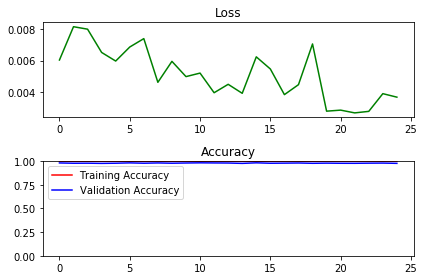

In [39]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(loss_epoch, 'g')
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(valid_acc_epoch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.legend(loc=2)
plt.tight_layout()
plt.show()

## investigating accuracy on out of sample data

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images=val_features, 
              true_labels=val_labels, 
              batch_size=150)


In [ ]:
accuracy

In [ ]:
# great, accuracy 99.74% on validation set.

In [ ]:
predicted_probabilities.shape

In [ ]:
predicted_probabilities[0]

In [ ]:
predicted_classes[0]

In [ ]:
certainty = predicted_probabilities.max(axis=1)

In [ ]:
plt.hist(certainty, bins=100);

In [ ]:
len(certainty[certainty<.98])

In [ ]:
plt.plot(certainty[certainty<.98]);

In [ ]:
# NOW test model predictions on test.p data which was not used in training or cross-validation

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images = x_test_norm, 
              true_labels = y_test_norm, 
              batch_size = 150)


In [ ]:
accuracy

In [ ]:
# 95.64% accuracy. great! model generalises very well! lets analyse what is working and what is not.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def print_test_accuracy(images, cls_pred, cls_true, 
                        show_example_errors=False,
                        show_confusion_matrix=False):
    num_test = len(images)
    num_classes = len(set(cls_true))

    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        incorrect = (correct == False)
        im = images[incorrect]
        cp = cls_pred[incorrect]
        ct = cls_true[incorrect]
        show_images(im, ct, 3, 4, labels_predicted=cp, random=False)
                
    if show_confusion_matrix:
        print("Confusion Matrix (log):")
        # Get the confusion matrix using sklearn.
        cm = confusion_matrix(y_true=cls_true,
                              y_pred=cls_pred)
        #print(cm)
        plt.matshow(np.log(cm))
        plt.colorbar()
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, range(num_classes))
        plt.yticks(tick_marks, range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()        

In [ ]:
# lets look at first 26x26 cells of confusion matrix
cm = confusion_matrix(y_true=y_test,
                      y_pred=predicted_classes)
np.set_printoptions(threshold=np.nan, linewidth=200)
print(cm[:25,:25])
np.set_printoptions(threshold=30, linewidth=75)

In [ ]:
# visualize example error images and confusion matrix
print_test_accuracy(images=X_test, 
                    cls_pred=predicted_classes, 
                    cls_true=y_test, 
                    show_example_errors=True, 
                    show_confusion_matrix=True)

In [ ]:
# read the sign names into a dict
import csv
reader = csv.DictReader(open('signnames.csv'))
signnames = {}
for row in reader:
    signnames[int(row['ClassId'])] = row['SignName']    

In [ ]:
# visualize instances where model is misclassifying big number of images

In [ ]:
def print_one_confusion(images, true_labels, predicted_labels, show_true_class, show_false_class):
    idx = np.logical_and(true_labels==show_true_class, predicted_labels==show_false_class)
    cnt = sum(idx)
    print('true class "{}", predicted class "{}". found: {}'.format(signnames[show_true_class], signnames[show_false_class], cnt))
    cols = int(np.ceil(cnt/10))
    show_images(images[idx], true_labels[idx], cols, 10, random=False, labels_predicted=predicted_labels[idx])

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=21, show_false_class=12)
# what we see here is the same test set image (may be with small transformations) that was misclassified.
# this seems like a genuine defficiency of the model -- the predicted sign is very different visually than the image

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=30, show_false_class=23)
# with this one it looks like the same image, with slight transformations. the quality is quite poor, so its 
# understandable that model had hard time predicting it. the shape of the sign is actually right. and the picture
# inside triangle is not very legible even for a human, so this is probably ok

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=7, show_false_class=5)
# we see in confusion matrix that all the speed limit signs have high misclassification errors between them.
# looks like the quality of the picture need to increase (better resolution is required)
# for model to be more discerning between different speed limits.

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=6, show_false_class=42)
# looks like in this case the model is confused by the 'end' part -- the line across the sign. so it used the shape
# and the cross line as main features. it also interpreted 80 as two vehicles passing each other (see below for
# images of the 'end of passing' sign examples)

In [ ]:
rows = 3
cols = 10
cls = 42
show_images(X_test, y_test, rows, cols, cls)

In [ ]:
x = normalize_data(im_array)
y = encoder.transform(im_true_label)

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images = x, 
              true_labels = y, 
              batch_size = 150)


In [ ]:
accuracy

In [ ]:
predicted_classes

In [ ]:
im_true_label

In [ ]:
rows = 3
cols = 10
cls = 11
show_images(X_test, y_test, rows, cols, cls)

In [ ]:
tsc.close_session()